# Task 1: Credit Scoring Model
 ## Intern: Abhijit Gain

## Import necessary Libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns


##  Dataset for Task 1

In [2]:
data = pd.read_csv('Credit_Card.csv')

## Process Target and Features 

In [3]:
target_col = 'default.payment.next.month'
X = data.drop(columns=[target_col])
y = data[target_col]

##  Train-Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Scaling Feature

In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

##  SMOTE with Imbalanced Data

In [6]:
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_scaled, y_train)

## Hyperparameter Tuning for GridSearchCV  setup

In [7]:
param_grids = {
    'Logistic Regression': {
        'C': [0.01, 0.1, 1, 10],
        'solver': ['lbfgs'],
        'max_iter': [500]
    },
    'Decision Tree': {
        'max_depth': [3, 5, 10, 20, None],
        'min_samples_split': [2, 5, 10]
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 10, 20, None],
        'min_samples_split': [2, 5, 10]
    }
}

models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42)
}

best_models = {}

for name, model in models.items():
    print(f"--- Hyperparameter tuning for {name} ---")
    grid = GridSearchCV(model, param_grids[name], cv=5, scoring='roc_auc', n_jobs=-1)
    grid.fit(X_train_res, y_train_res)
    print(f"Best params for {name}: {grid.best_params_}")
    best_models[name] = grid.best_estimator_

print("\n\n--- Model Evaluation on Test Set ---")

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_proba = model.decision_function(X_test)
    else:
        y_proba = None

    print(classification_report(y_test, y_pred, digits=4))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    if y_proba is not None:
        print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))
    print('-' * 50)

--- Hyperparameter tuning for Logistic Regression ---
Best params for Logistic Regression: {'C': 1, 'max_iter': 500, 'solver': 'lbfgs'}
--- Hyperparameter tuning for Decision Tree ---
Best params for Decision Tree: {'max_depth': 10, 'min_samples_split': 10}
--- Hyperparameter tuning for Random Forest ---
Best params for Random Forest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}


--- Model Evaluation on Test Set ---


## Test set

In [8]:
for name, model in best_models.items():
    print(f"Evaluating {name}...")
    evaluate_model(model, X_test_scaled, y_test)


Evaluating Logistic Regression...
              precision    recall  f1-score   support

           0     0.8667    0.6831    0.7640      4673
           1     0.3608    0.6300    0.4588      1327

    accuracy                         0.6713      6000
   macro avg     0.6137    0.6565    0.6114      6000
weighted avg     0.7548    0.6713    0.6965      6000

Confusion Matrix:
 [[3192 1481]
 [ 491  836]]
ROC-AUC Score: 0.7103753529027486
--------------------------------------------------
Evaluating Decision Tree...
              precision    recall  f1-score   support

           0     0.8601    0.8115    0.8351      4673
           1     0.4463    0.5350    0.4866      1327

    accuracy                         0.7503      6000
   macro avg     0.6532    0.6733    0.6608      6000
weighted avg     0.7685    0.7503    0.7580      6000

Confusion Matrix:
 [[3792  881]
 [ 617  710]]
ROC-AUC Score: 0.7160758198059659
--------------------------------------------------
Evaluating Random Fore

## Feature Importance (Random Forest )


--- Top 10 Important Features ---
PAY_0        0.101462
LIMIT_BAL    0.072505
ID           0.056576
AGE          0.053606
PAY_2        0.051869
PAY_AMT1     0.047452
BILL_AMT1    0.046708
PAY_AMT2     0.045955
PAY_AMT6     0.045642
PAY_AMT3     0.042669
dtype: float64


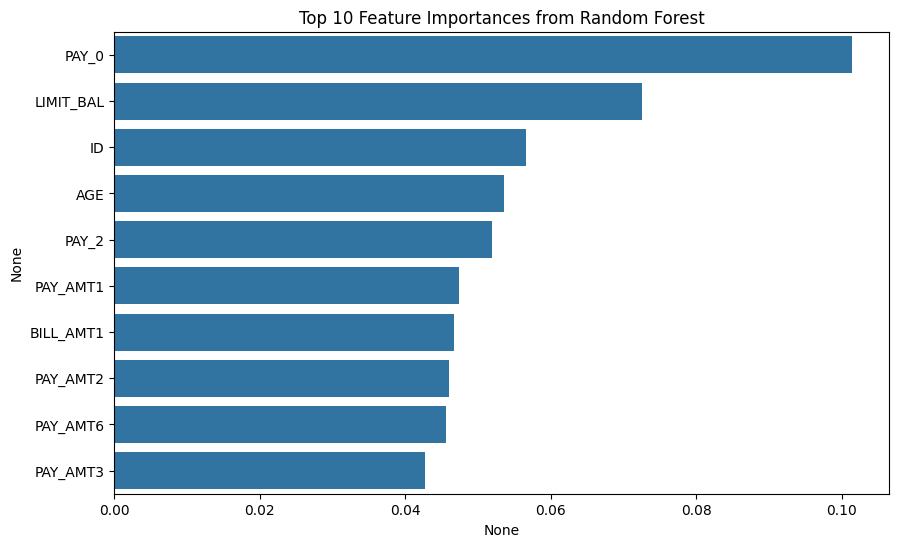

In [9]:
rf_model = best_models['Random Forest']
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)

print("\n--- Top 10 Important Features ---")
print(feature_importances.head(10))

# Feature importance visualization
plt.figure(figsize=(10,6))
sns.barplot(x=feature_importances.head(10), y=feature_importances.head(10).index)
plt.title('Top 10 Feature Importances from Random Forest')
plt.show()

##  Cross-validation (ROC-AUC )

In [10]:
print("\n--- Cross-validation Scores (ROC-AUC) ---")
for name, model in best_models.items():
    scores = cross_val_score(model, X_train_res, y_train_res, cv=5, scoring='roc_auc', n_jobs=-1)
    print(f"{name}: Mean ROC-AUC = {scores.mean():.4f}, Std = {scores.std():.4f}")


--- Cross-validation Scores (ROC-AUC) ---
Logistic Regression: Mean ROC-AUC = 0.7356, Std = 0.0042
Decision Tree: Mean ROC-AUC = 0.8226, Std = 0.0536
Random Forest: Mean ROC-AUC = 0.9371, Std = 0.0350
